<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/trading/Extreme_Shitcoin_Perp_Carry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extreme Shitcoin Perp Carry Trade

* Rank perps by their 24h avg funding
* Long the top 5 / short the bottom 5
* Rebalance daily
* Be patient with trading. Split it into bit and mostly quote in.

IT'S ABOUT A 100 VOL STRATEGY AND YOU'D BE TRADING ABOSLUTE TRASH. 

SO IF YOU DECIDE TO DO THIS AT HOME, DO IT EXTREMELY SMALL!

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c(), extra_dependencies = c())

# cat(debug_msg)

# snippet: re set plot options v0.1
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# What data do we want?

* Perp prices
* Perp funding rates

In [2]:
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw crypto load ftx futures v0.1
futures <- rwRtools::crypto_get_futures()

futures %>% 
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

# snippet: rw crypto load ftx perpetual funding rates v0.1
perp_rate <- rwRtools::crypto_get_perp_rates()

perp_rate %>%
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 232.4…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-07-20 12:00:00,2022-11-12


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-03-06 15:00:00,2022-11-12


# Prepare Data for Analysis

Calculate returns

* Positive rate = longs pay shorts
* Negative rate = shorts pay longs

We convert all rates to be the returns to longs.

In [4]:
perp_rate %>% head()

ticker,date,rate
<chr>,<dttm>,<dbl>
1INCH-PERP,2020-12-25 03:00:00,0.000000
1INCH-PERP,2020-12-25 04:00:00,0.000000
1INCH-PERP,2020-12-25 05:00:00,0.000000
1INCH-PERP,2020-12-25 06:00:00,0.000558
1INCH-PERP,2020-12-25 07:00:00,0.000120
1INCH-PERP,2020-12-25 08:00:00,0.000123


In [5]:
funding_data <- futures %>% 
  inner_join(perp_rate, by = c('ticker','date')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    price_change = log(close / lag(close)),
    funding_accrual = -lead(rate)
  ) %>% 
  na.omit()

Downsample to daily

In [6]:
daily_funding <- funding_data %>%
  mutate(date = as_date(date)) %>%
  group_by(ticker, date) %>%
  summarize(
    volume = sum(volume),
    price_change = sum(price_change),
    funding_accrual = sum(log(funding_accrual + 1)),
  ) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(avg_24 = lag(funding_accrual)) %>%
  na.omit()

daily_funding %>% head()

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,volume,price_change,funding_accrual,avg_24
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
ALGO-PERP,2019-07-21,159066.40,-0.021104448,-4.950140e-04,-4.700141e-05
ALT-PERP,2019-07-21,197649.87,-0.007201677,-4.770134e-04,1.999946e-04
BCH-PERP,2019-07-21,41817.78,-0.012713350,9.959737e-04,5.299804e-04
BNB-PERP,2019-07-21,226812.72,-0.024189491,-4.930141e-04,-3.360068e-04
BSV-PERP,2019-07-21,222996.06,0.018024672,-5.901206e-05,-1.980034e-04
BTC-PERP,2019-07-21,74002919.33,-0.016577682,1.559984e-04,-1.300012e-04


Let's sort cross-sectionally by ticker and then by date

In [7]:
daily_returns <- daily_funding %>%
  group_by(date) %>%
  mutate(
    short_funding_rank = row_number(avg_24),
    long_funding_rank = row_number(-avg_24),
    position = case_when(short_funding_rank <= 5 ~ "Short", long_funding_rank <= 5 ~ "Long")
  ) %>%
  ungroup() %>%
  group_by(date, position) %>%
  summarize(
    price_change = mean(price_change),
    funding_accrual = mean(funding_accrual)
  )

daily_returns %>% head()

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


date,position,price_change,funding_accrual
<date>,<chr>,<dbl>,<dbl>
2019-07-21,Long,-0.0050772781,-1.613275e-06
2019-07-21,Short,-0.0004386819,-1.048867e-03
2019-07-21,NA,-0.0149201755,-1.477560e-04
2019-07-22,Long,-0.0310734887,-1.010121e-04
2019-07-22,Short,-0.0384496586,-1.556306e-03
2019-07-22,NA,-0.0341601723,-2.862581e-04


Let's do a little simulation of:
 - long the top 5
 - short the bottom 5

 rebalancing every day

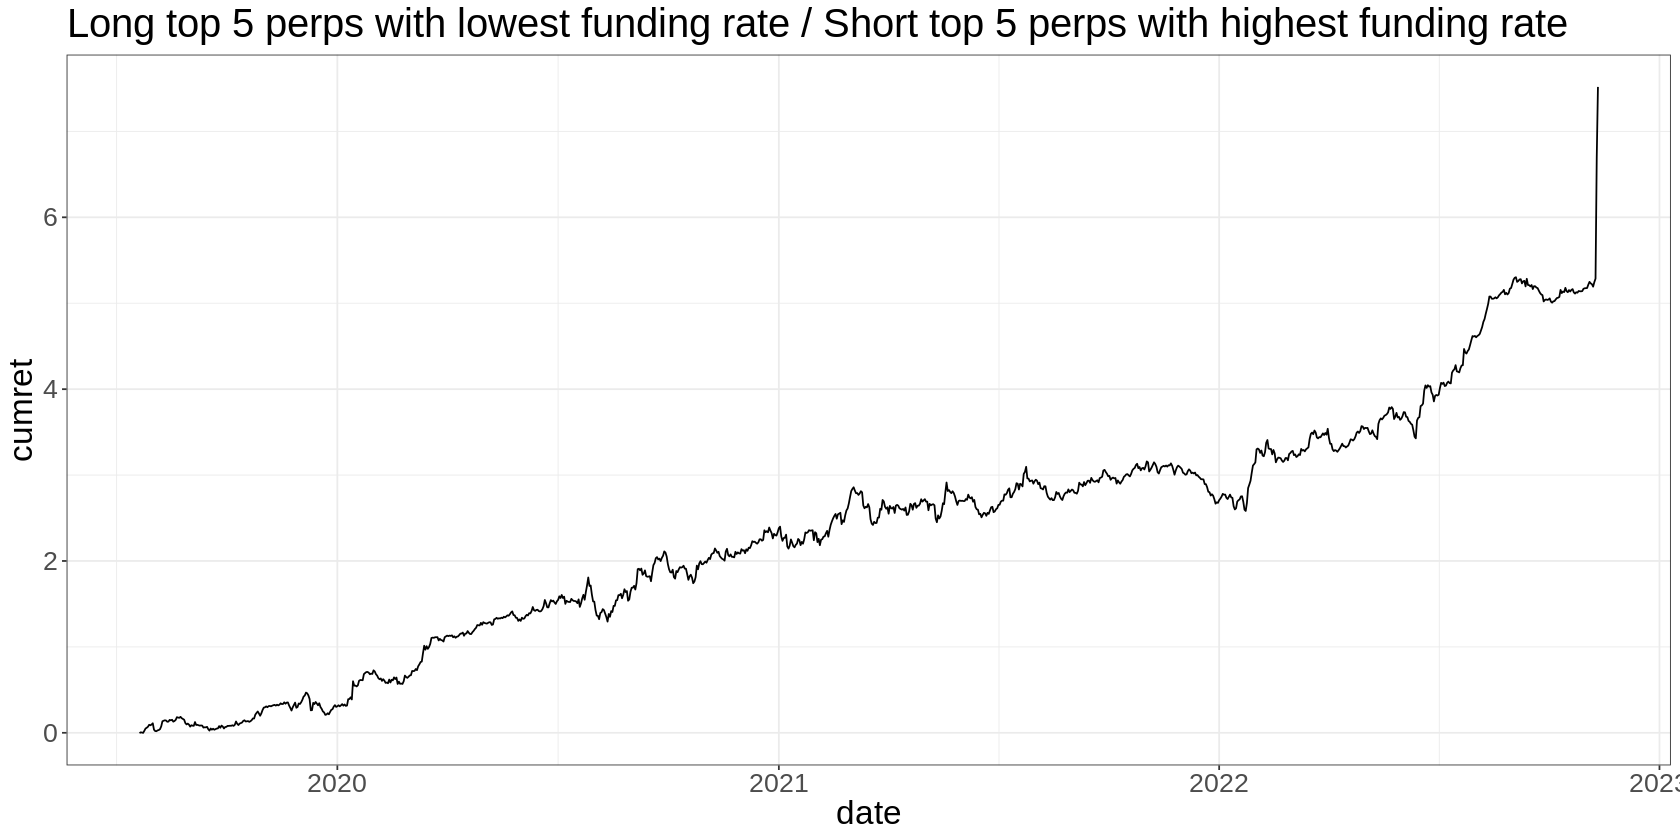

In [8]:
daily_returns %>% 
  filter(!is.na(position)) %>%
  mutate(
    total_returns = case_when(position == 'Long' ~ price_change + funding_accrual, position == 'Short' ~ -(price_change + funding_accrual))
  ) %>%
  group_by(date) %>%
  summarize(total_returns = sum(total_returns)) %>%
  arrange(date) %>%
  mutate(cumret = cumsum(total_returns)) %>%
  ggplot(aes(x=date, y=cumret)) + geom_line() + 
    ggtitle('Long top 5 perps with lowest funding rate / Short top 5 perps with highest funding rate')

How often does this switch positions

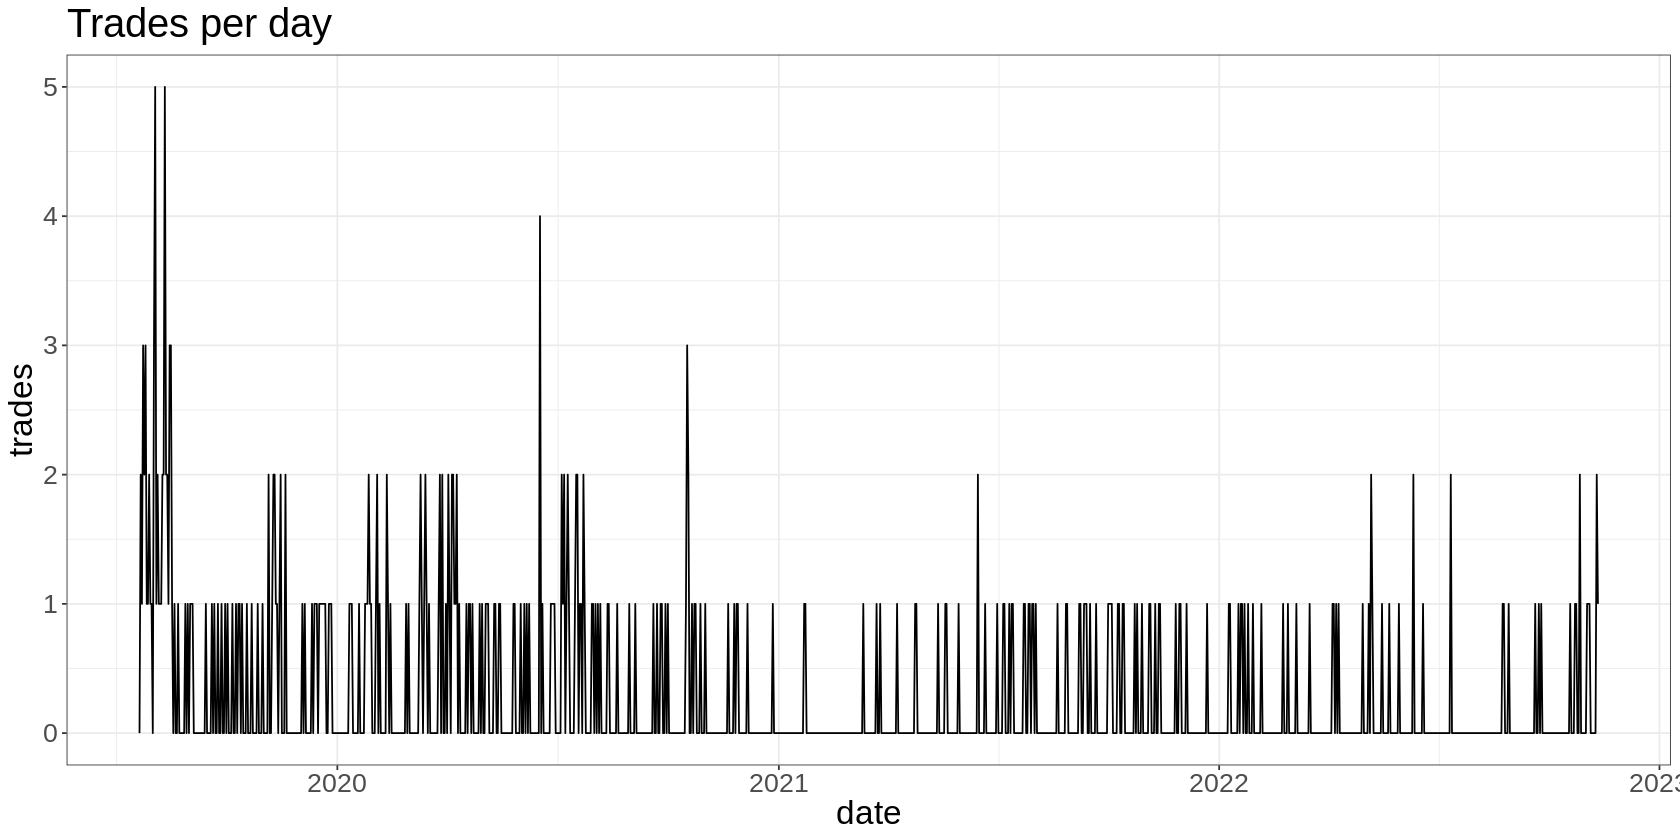

In [9]:
trades <- daily_funding %>%
  group_by(date) %>%
  mutate(
    short_funding_rank = row_number(avg_24),
    long_funding_rank = row_number(-avg_24),
    position = case_when(short_funding_rank <= 5 ~ "Short", long_funding_rank <= 5 ~ "Long")
  ) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(trade = case_when(position != lag(position) ~ 1, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarize(trades = sum(trade))

trades %>% 
  ggplot(aes(x=date, y=trades)) + geom_line() + ggtitle('Trades per day')

Average trades per day is... 

In [10]:
trades %>% summarize(mean(trades))

mean(trades)
<dbl>
0.2793388


Assume 0.5% Trading Cost

In [11]:
trading_cost_pct <- 0.5

trades <- trades %>% 
  ungroup() %>%
  mutate(cost = trades * 0.1 * (trading_cost_pct/100))

trades %>%
  summarize(cost_pct = mean(cost) * 100)

cost_pct
<dbl>
0.01396694


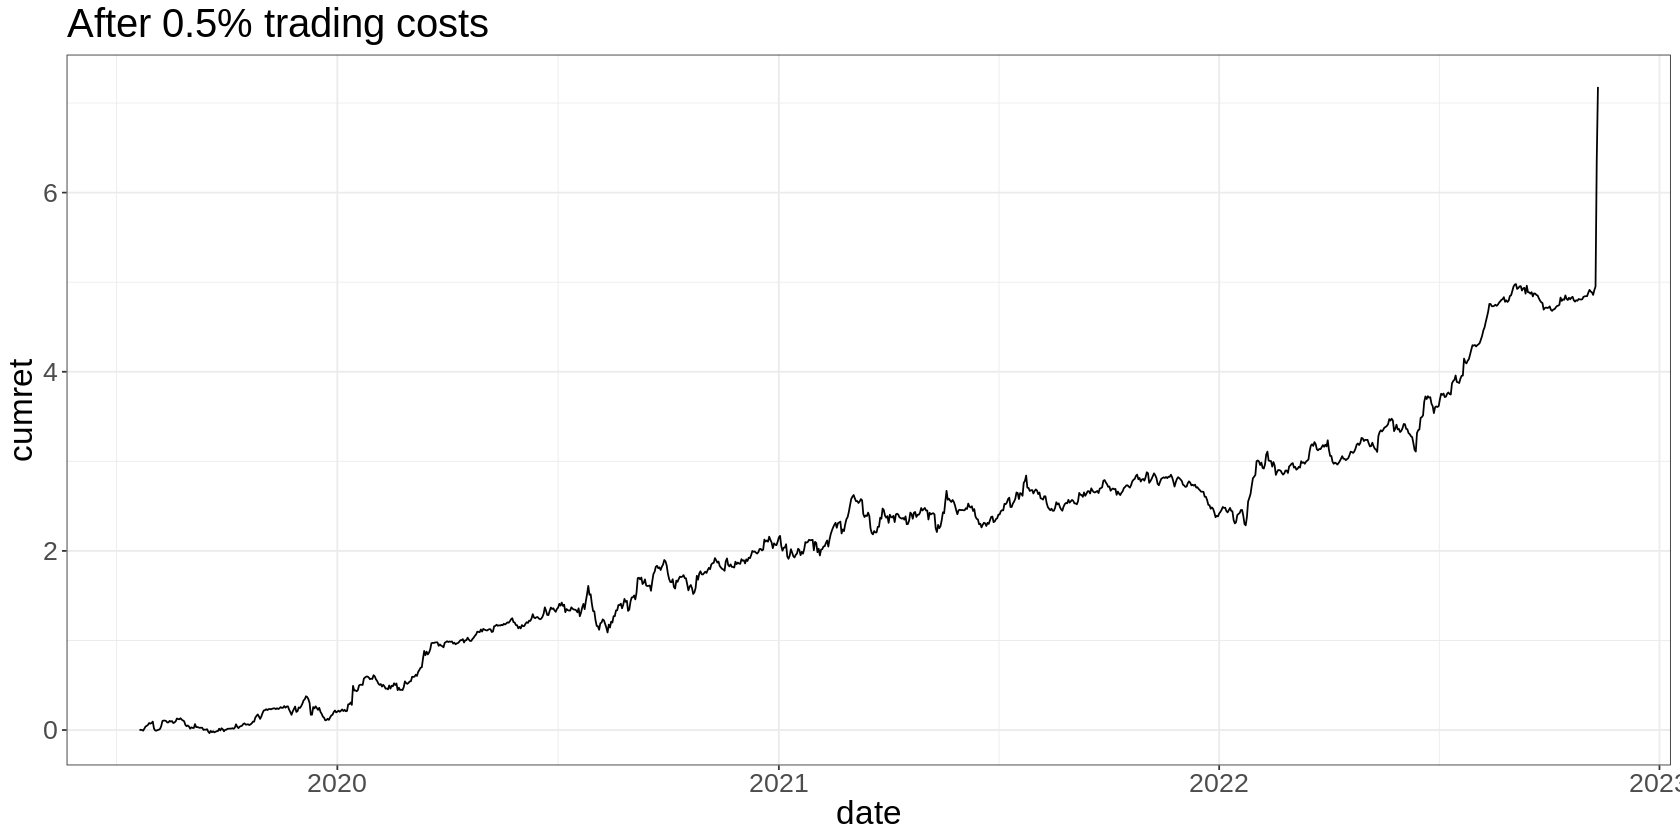

In [12]:
daily_returns %>% 
  inner_join(trades, by = 'date') %>%
  filter(!is.na(position)) %>%
  mutate(
    total_returns = case_when(position == 'Long' ~ price_change + funding_accrual, position == 'Short' ~ -(price_change + funding_accrual))
  ) %>%
  group_by(date) %>%
  summarize(total_returns = sum(total_returns - cost)) %>%
  arrange(date) %>%
  mutate(cumret = cumsum(total_returns)) %>%
  ggplot(aes(x=date, y=cumret)) + geom_line() + 
    ggtitle('After 0.5% trading costs')

What is the vol of this face-ripper?

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



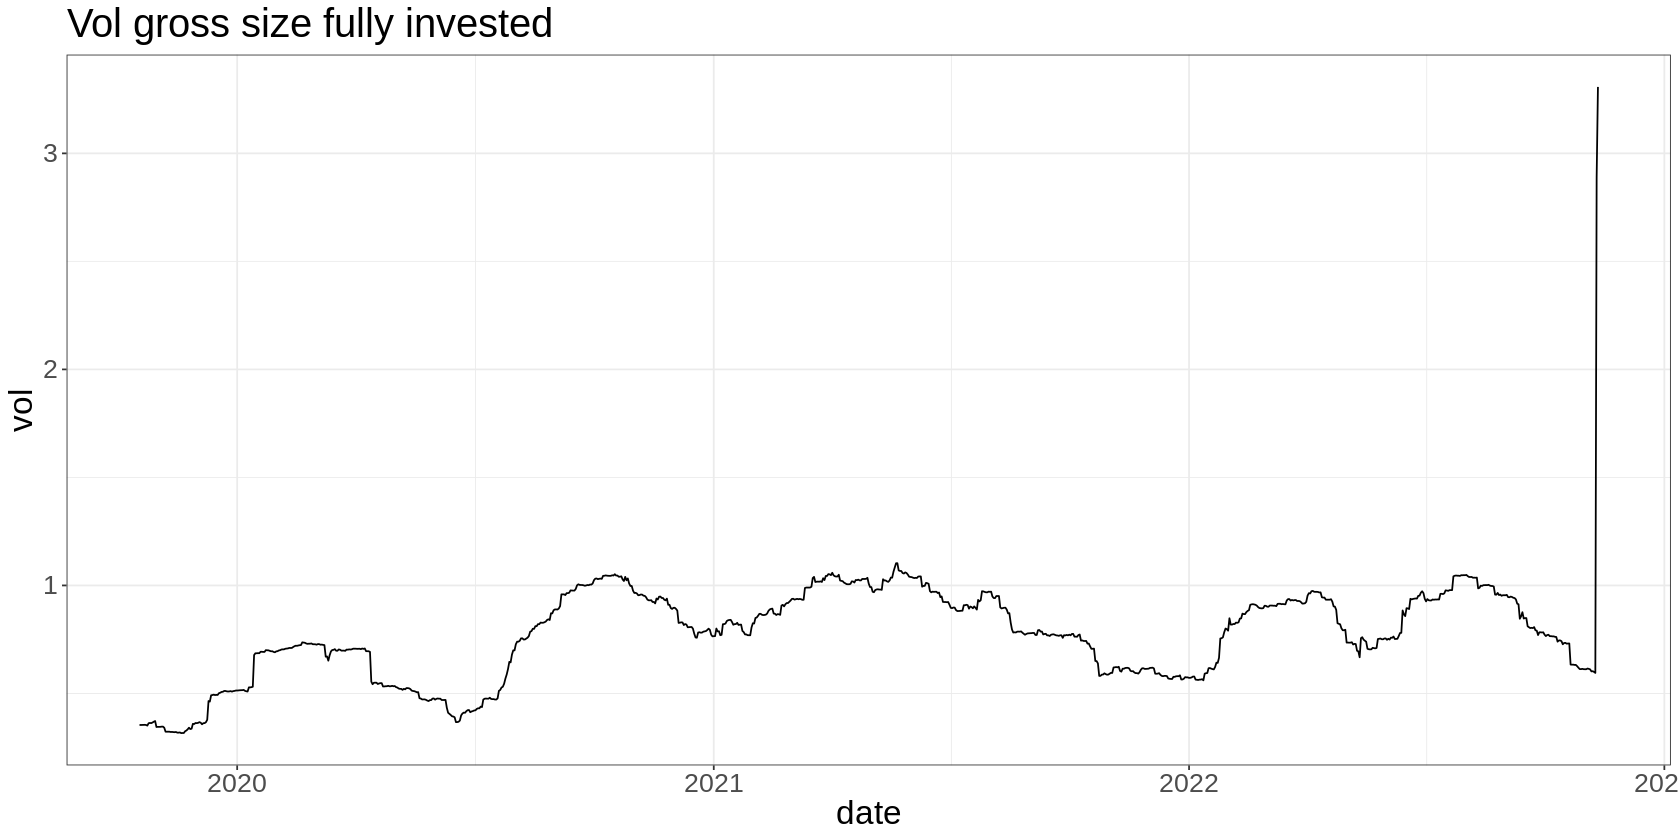

In [13]:
install.packages("roll")
library(roll)

daily_returns %>% 
  inner_join(trades, by = 'date') %>%
  filter(!is.na(position)) %>%
  mutate(
    total_returns = case_when(position == 'Long' ~ price_change + funding_accrual, position == 'Short' ~ -(price_change + funding_accrual))
  ) %>%
  group_by(date) %>%
  summarize(total_returns = sum(total_returns - cost)) %>%
  arrange(date) %>%
  mutate(vol = roll_sd(total_returns, 90) * sqrt(365)) %>%
  na.omit() %>%
  ggplot(aes(x=date, y=vol)) + geom_line() + 
    ggtitle('Vol gross size fully invested')